## 1- Filter CVD Death Patients
Remove all the NON-CVD death patients. Here we take in input the original dataset and output the original dataset with only CVD Death patients:
- Input: data.csv
- Output: data_cvd.csv

In [10]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 500,

    # saving settings for latex
    # https://timodenk.com/blog/exporting-matplotlib-plots-to-latex/
    # "pgf.texsystem": "pdflatex",
    # "font.family": "serif",
    # "text.usetex": True,
    # "pgf.rcfonts": False,
    })

%matplotlib inline

In [28]:
# load data
df = pd.read_csv("./data/cad/data.csv", index_col=0, decimal='.')
df.convert_dtypes()
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%m/%d/%Y")
df["Data prelievo"] = pd.to_datetime(df["Data prelievo"], format="%m/%d/%Y")

In [29]:
# remove ONLY and ALL the deaths patients NON-CVD (Fatal MI or Sudden death, UnKnown, Accident, Suicide)
total = df[df["Total mortality"]==1].index
cvd_idx = df[df["CVD Death"]==1].index
noncvd_idx = set(total) - set(cvd_idx)

print(f"Total deaths: {len(total)}")
print(f"Death CVD: {len(cvd_idx)}")
print(f"Death Non-CVD: {len(noncvd_idx)}")

df_cvd = df.drop(noncvd_idx)
print(f"\nTotal patients: {len(df)}")
print(f"Total patients (after removal of Death Non-CVD): {len(df_cvd)}")
# df.info()

assert len(noncvd_idx) == len(total) - len(cvd_idx)
assert len(df.columns) == len(df_cvd.columns)
# df_cvd.to_csv("data/cad/data_cvd.csv")

Total deaths: 1587
Death CVD: 757
Death Non-CVD: 830

Total patients: 4817
Total patients (after removal of Death Non-CVD): 3987


## 2- Clean Irrelevant Features
From the only CVD death patients, we remove all the irrelevant features for the classification task. We also create a target feature. 
- Input: data_cvd.csv
- Output: data_cvd_clean.csv

In [6]:
df_cvd = pd.read_csv("./data/cad/data_cvd.csv", index_col=0, decimal='.')
df_cvd["Follow Up Data"] = pd.to_datetime(df_cvd["Follow Up Data"])
df_cvd["Data prelievo"] = pd.to_datetime(df_cvd["Data prelievo"])

Text(0, 0.5, 'Patients')

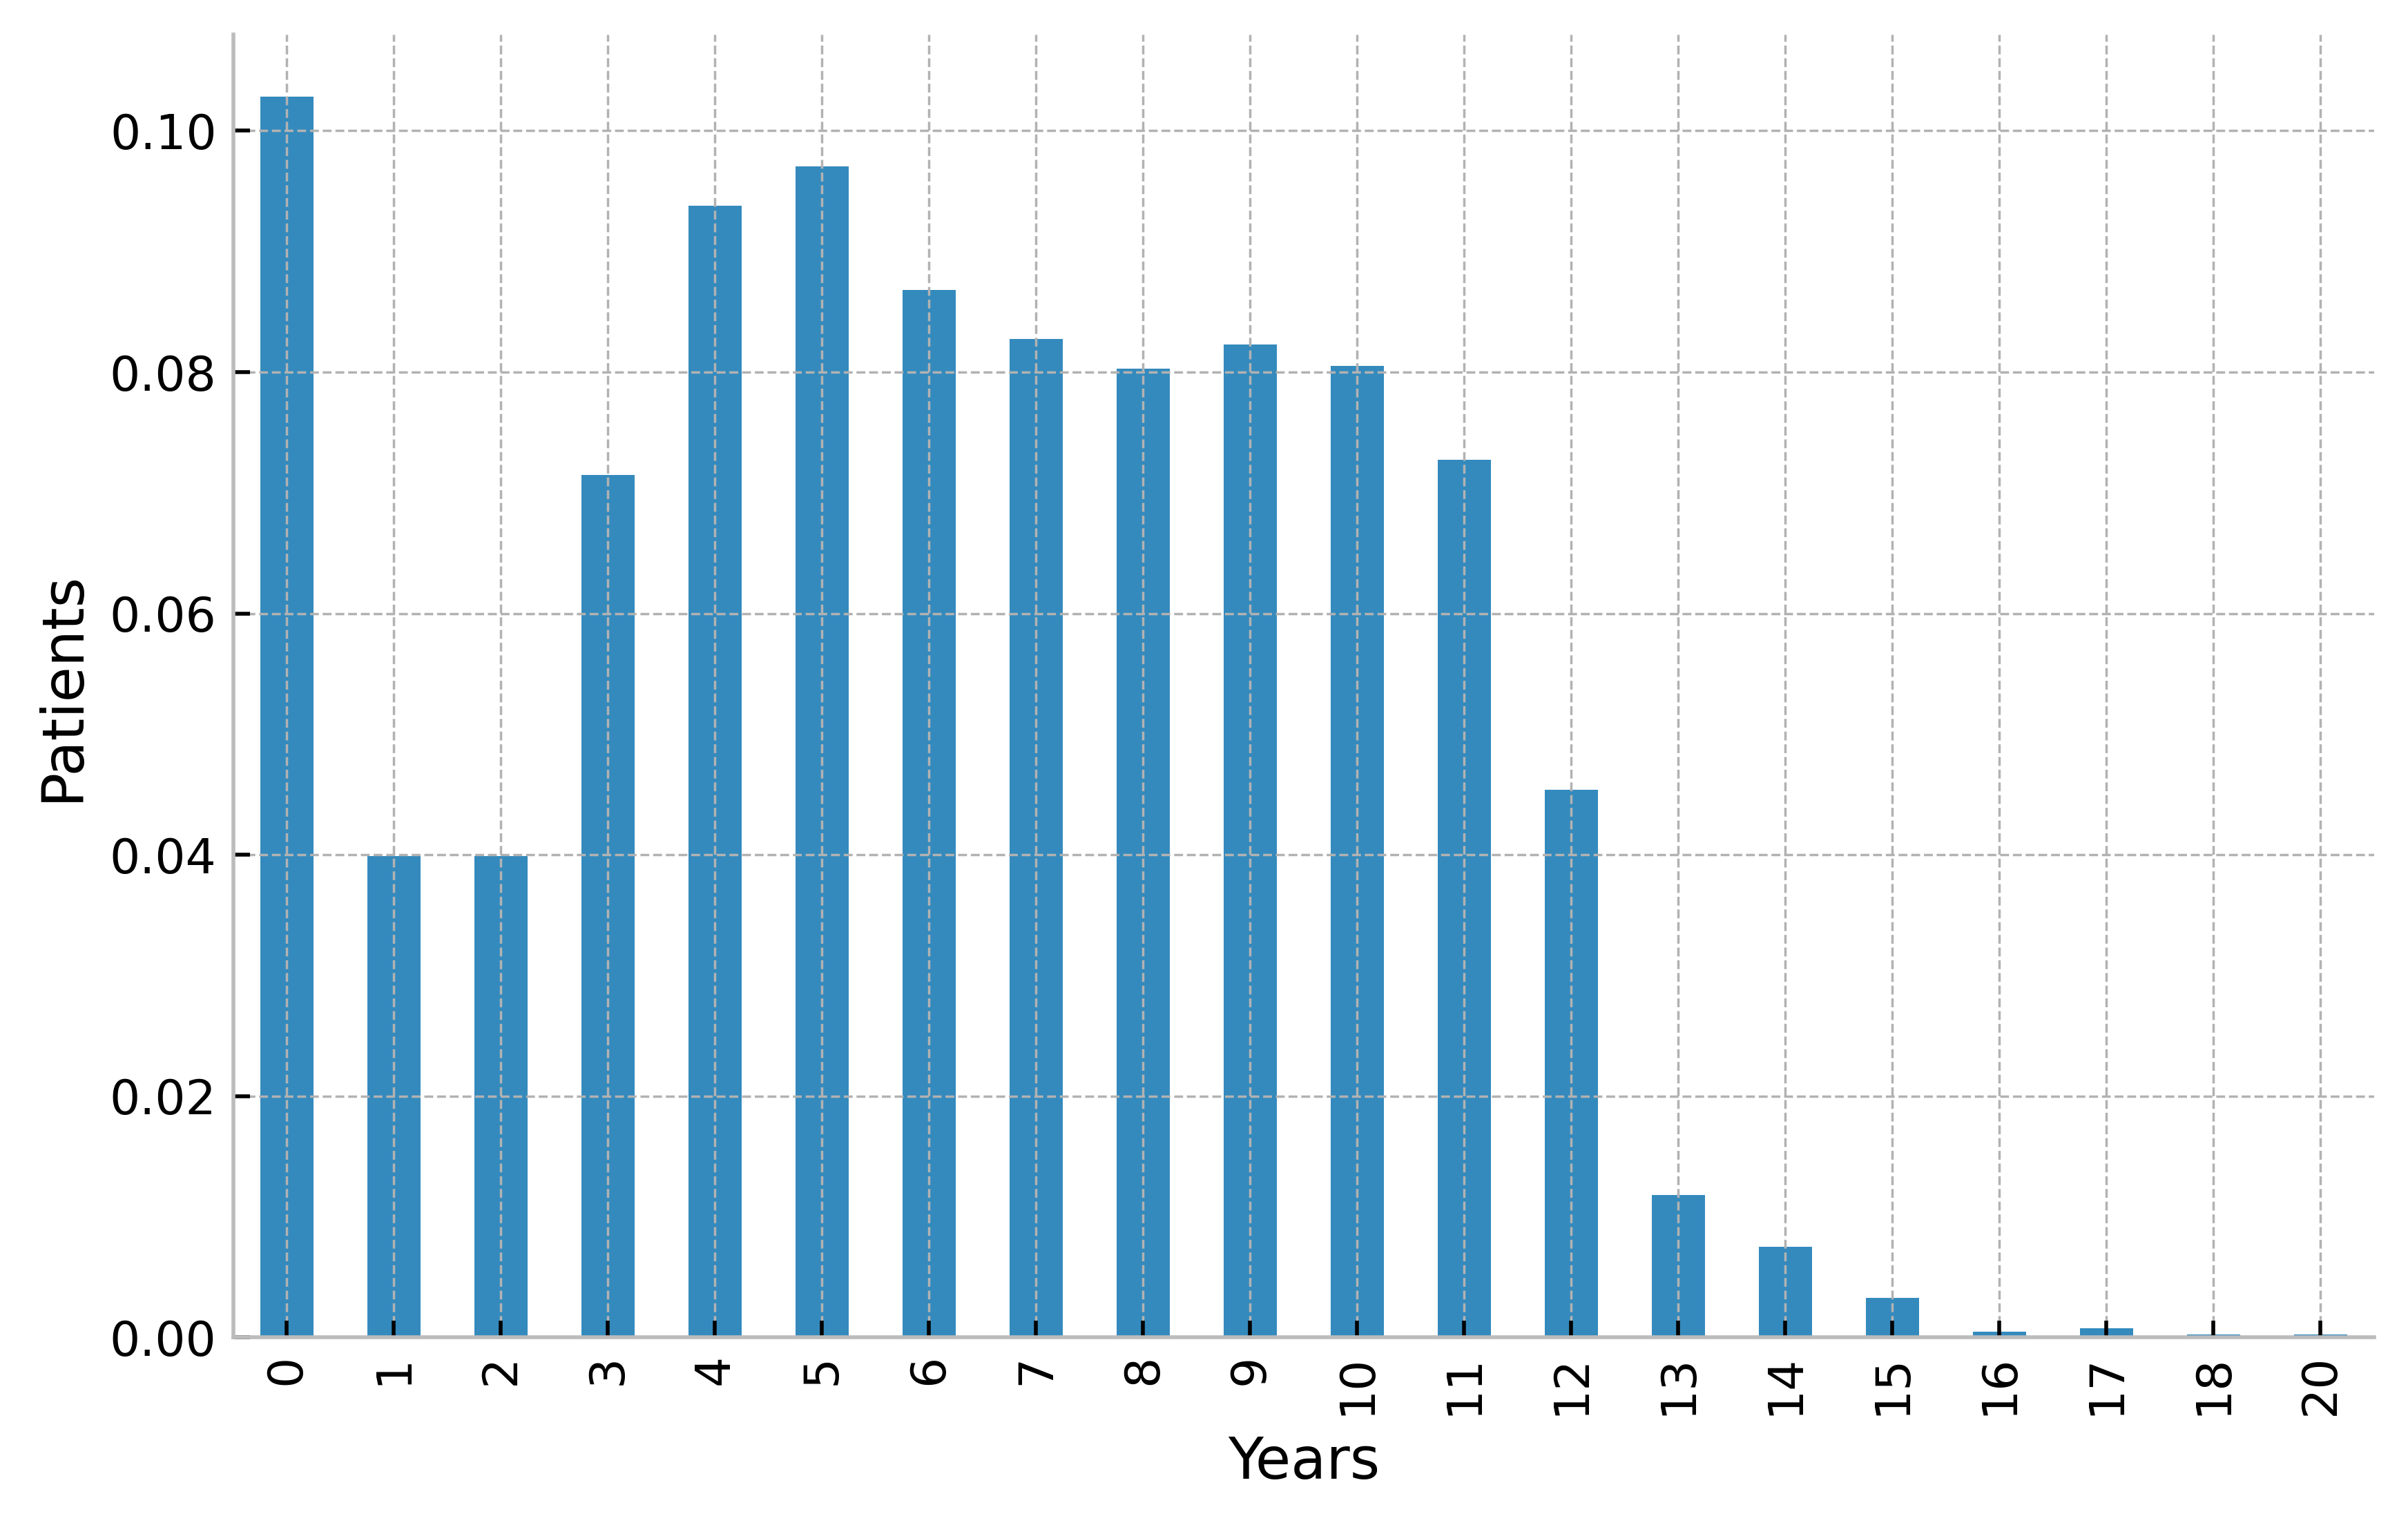

In [12]:
# compute difference between dates: follow up and admission
figure = plt.figure(dpi=500)
df_diff = (df_cvd["Follow Up Data"] - df_cvd["Data prelievo"]).map(lambda x: x.days // 365)
df_diff.value_counts(normalize=True).sort_index().plot(kind='bar', figsize=(8,5), ax=plt.gca())
# plt.title("Distribution of the difference between Follow up - Recovery")
plt.xlabel("Years")
plt.ylabel("Patients")

In [16]:
# complete vessels feature, if CAD == 0 then Vessels can be set to 0, otherwise we don't know the Vessels
for i in df_cvd.index:
    if (pd.isna(df_cvd["Vessels"][i]) and df_cvd["CAD"][i]==0):
        df_cvd.loc[i, "Vessels"] = 0
    elif (pd.isna(df_cvd["Vessels"][i]) and df_cvd["CAD"][i]==1):
        df_cvd.loc[i, "Vessels"] = -1

# clean features remove follow up features
df_feat = df_cvd.copy()
df_feat = pd.concat([df_feat.iloc[:, :30], df_feat.iloc[:, 40:]], axis=1)
df_feat = df_feat.drop(columns=["Data of death", "Data prelievo", "Follow Up Data", "Durata Follow Up",
                                "Fatal MI or Sudden death", "UnKnown", "Accident", "Total mortality", 
                                "CVD Death", "CAD"])

# create and add target feature
years = 7
survive = (df_diff < years) & df_cvd["CVD Death"]
survive = (survive + 1) % 2
df_feat[f"Survive{years}Y"] = survive

print("Total patient: \t", len(df_feat))
print("Survived: \t", df_feat[f"Survive{years}Y"].sum(), "\t", df_feat[f"Survive{years}Y"].sum()/len(df_feat))
print("Dead: \t\t", len(df_feat)-df_feat[f"Survive{years}Y"].sum(), "\t", (len(df_feat)-df_feat[f"Survive{years}Y"].sum())/len(df_feat))
df_feat = df_feat.convert_dtypes()
# df_feat.info()

# df_feat.to_csv("data/cad/data_feat.csv")

Total patient: 	 3987
Survived: 	 3358 	 0.8422372711311763
Dead: 		 629 	 0.15776272886882367


In [19]:
df_feat.columns

Index(['Gender (Male = 1)', 'Age', 'Angina', 'Previous CABG', 'Previous PCI',
       'Previous Myocardial Infarction', 'Acute Myocardial Infarction',
       'Angiography', 'Vessels', 'FE',
       'Documented resting \nor exertional ischemia',
       'Post-ischemic Dilated\nCardiomyopathy', 'Smoke\nHistory of smoke',
       'Diabetes\nHistory of diabetes',
       'Hypertension\nHistory of hypertension',
       'Hyperlipemia\nHistoty of hyperlipemia',
       'Paroxysmal or chronic \natrial fibrillation', 'Survive7Y'],
      dtype='object')

## Extra utilities
Create and save the subset datagroups

In [7]:
# dataset train, valid, test split
def split_and_save(df, path, verbose=True):
    from sklearn.model_selection import train_test_split
    df_train, df_test = train_test_split(df, test_size=0.2, stratify=df.iloc[:,-1])
    df_train, df_valid = train_test_split(df_train, test_size=0.25, stratify=df_train.iloc[:,-1])

    df_train.to_csv(f"{path}train.csv")
    df_valid.to_csv(f"{path}valid.csv")
    df_test.to_csv(f"{path}test.csv")

    if verbose: 
        print("Train: \t", len(df_train))
        print("Valid: \t", len(df_valid))
        print("Test: \t", len(df_test))

In [10]:
split_and_save(df_feat, "data/cad/")

Train: 	 2391
Valid: 	 798
Test: 	 798


In [11]:
from collections import Counter
df_train = pd.read_csv("./data/cad/train.csv", index_col=0, decimal='.')
df_valid = pd.read_csv("./data/cad/valid.csv", index_col=0, decimal='.')
df_test = pd.read_csv("./data/cad/test.csv", index_col=0, decimal='.')
print(Counter(df_train["Survive7Y"]))
print(Counter(df_valid["Survive7Y"]))
print(Counter(df_test["Survive7Y"]))

Counter({1: 2014, 0: 377})
Counter({1: 672, 0: 126})
Counter({1: 672, 0: 126})


In [25]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(35,30))
sns.heatmap(df_feat.corr(), annot=True)
# fig.savefig("feat.pdf")